In [1]:
import numpy as np
import pandas as pd
import mosqlient as mosq
from epiweeks import Week
from prophet import Prophet
import matplotlib.pyplot as plt

The code below is used since my api_key is saved on an .env file: 

In [2]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the environment variables
api_key = os.getenv('API_KEY')

# Creating a simple forecasting model

Here we will create a simple forecasting model using the `prophet` library.

## Downloading the Dengue dataset

We will build a simple univariate model using only dengue cases. To fetch the data directly from the API, we'll use the Mosqlient library. To download the data in `.csv.gz` format for all the states, [click here](https://sprint.mosqlimate.org/data/).


Our analysis will use data on Distrito Federal (DF).

In [3]:
start_date = str(Week(2023, 25).startdate())
end_date = str(Week(2024, 40).startdate())
start_date, end_date

('2023-06-18', '2024-09-29')

In [4]:
df = mosq.get_infodengue(
    api_key = api_key,
    disease = 'dengue',
    uf = 'DF',
    start_date = '2010-01-01',
    end_date = end_date)

#select columns and rename the `casprov` column.
columns = ['data_iniSE', 'SE', 'municipio_geocodigo', 'casprov', 'Rt', 'p_rt1']

df = df[columns].rename(columns = {'casprov':'casos', 'data_iniSE':'date'})

df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(by = 'date')

df.head()

100%|██████████| 2/2 [00:02<00:00,  1.14s/requests]


,date,SE,municipio_geocodigo,casos,Rt,p_rt1
769,2010-01-03,201001,5300108,107.0,0.0,0.0
768,2010-01-10,201002,5300108,219.0,0.0,0.0
767,2010-01-17,201003,5300108,284.0,0.0,0.0
766,2010-01-24,201004,5300108,372.0,0.0,0.0
765,2010-01-31,201005,5300108,474.0,0.0,0.0


Let's prepare the dataset, renaming the columns to match the `prophet` library requirements. The library requires a `ds` column for the date and a `y` column for the value to be predicted. 

In [5]:
df = df.set_index('date')[['casos']].resample('W').sum().reset_index()

df = df.rename(columns = {'casos': 'y', 'date': 'ds'})

df.head()

,ds,y
0,2010-01-03,107.0
1,2010-01-10,219.0
2,2010-01-17,284.0
3,2010-01-24,372.0
4,2010-01-31,474.0


To ensure data is always positive and at the same scale, we will use the log of the number of cases. 

In [6]:
df_train = df.loc[df.ds <= start_date][['ds', 'y']]

df_train['y'] = np.log1p(df_train['y'])

df_train.head()

,ds,y
0,2010-01-03,4.682131
1,2010-01-10,5.393628
2,2010-01-17,5.652489
3,2010-01-24,5.921578
4,2010-01-31,6.163315


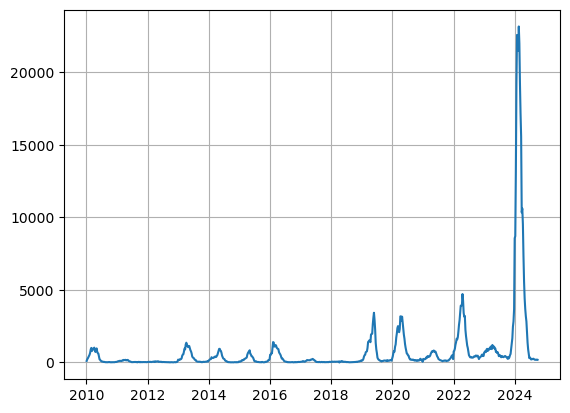

In [7]:
# Plot the training data
_, ax = plt.subplots()

ax.plot(df.ds, df.y, label = 'Casos')
ax.grid()
plt.show()

Let's define and train the model:

In [8]:
# Initialize and fit the model
model = Prophet(weekly_seasonality=True, yearly_seasonality=True, daily_seasonality=False, mcmc_samples = 100)
model.fit(df_train)

07:12:56 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

07:13:01 - cmdstanpy - INFO - CmdStan done processing.
07:13:01 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_

## Making in-sample predictions

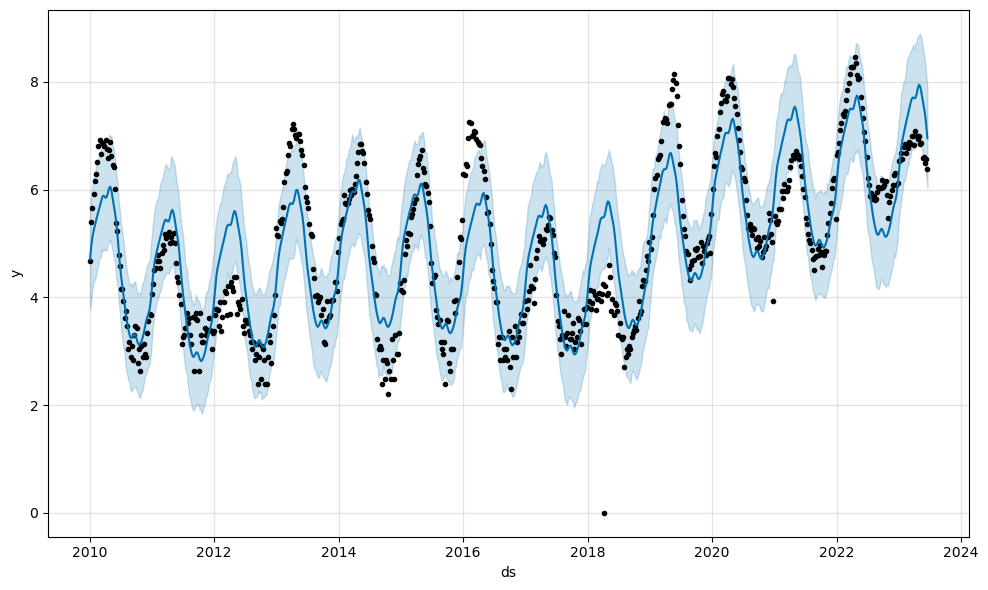

In [9]:
# Create a dataframe to hold predictions
dates = model.make_future_dataframe(periods=68, freq='W')
in_sample = dates[dates['ds'] <= start_date]

# Make predictions
forecast = model.predict(in_sample)
# Plot the forecast
fig1 = model.plot(forecast)

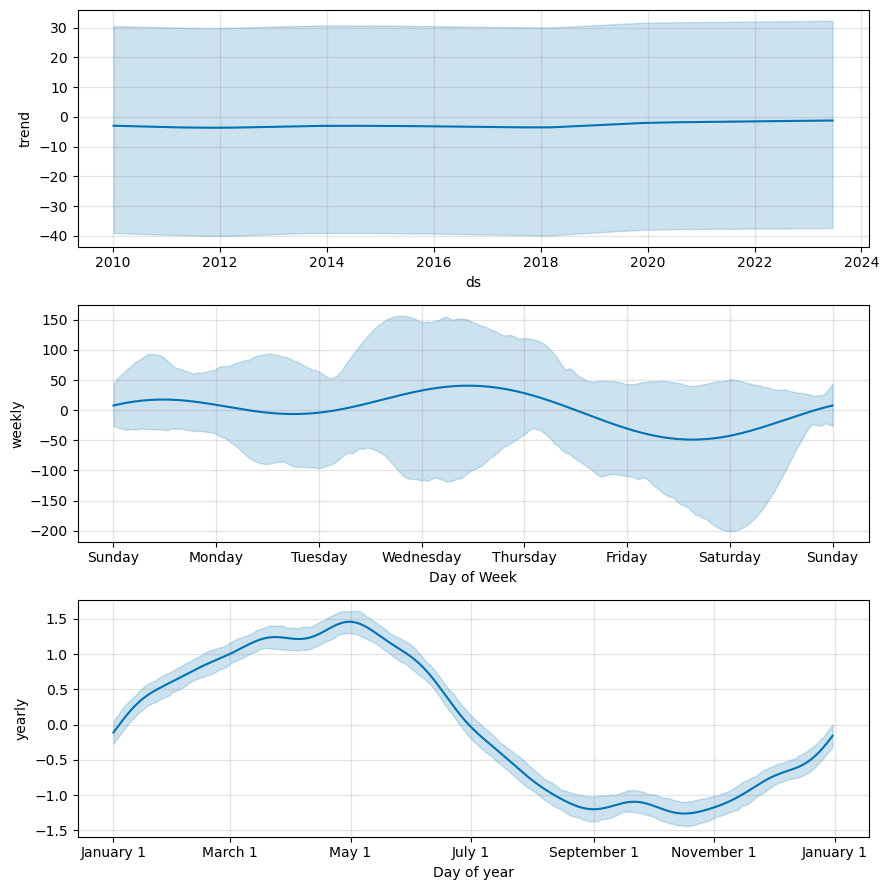

In [10]:
# plot the forecast components
fig2 = model.plot_components(forecast)

## Using the model for forecasting:

In [11]:
# Create a dataframe to hold predictions
start_for = str(Week(2023, 41).startdate())
future = dates[dates['ds'] >= start_for]
samples = model.predictive_samples(future)
yhat_samples = samples['yhat']

In [12]:
# Creating dataframe with the forecasted values and confidence intervals in the format required by the sprint   
np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T.shape
for_data = np.expm1(np.percentile(yhat_samples, [2.5, 5, 10, 25, 50, 75, 90, 95, 97.5], axis=1).T)

df_forecast = pd.DataFrame(for_data, columns = ['lower_95', 'lower_90', 'lower_80', 'lower_50',
                                  'pred', 'upper_50', 'upper_80', 'upper_90', 'upper_95'])

df_forecast['date'] =  pd.to_datetime(np.array(future['ds']))

df_forecast.head()

,lower_95,lower_90,lower_80,lower_50,pred,upper_50,upper_80,upper_90,upper_95,date
0,45.737527,57.143734,72.660610,120.334510,205.384798,355.894679,609.077319,740.530014,935.643688,2023-10-08
1,45.204839,57.117125,75.455335,118.567940,191.174176,325.650567,506.899850,680.014522,814.328556,2023-10-15
2,44.983057,61.201542,78.053733,124.915305,212.576024,353.746062,557.931053,740.072564,922.028589,2023-10-22
3,46.806437,56.462913,74.469464,120.465795,208.123894,358.304933,586.961229,824.402203,1064.230437,2023-10-29
4,56.851900,68.003060,90.024590,137.953002,227.441509,362.391709,581.971019,756.485972,949.311613,2023-11-05


## Uploading the forecasts to the Mosqlimate platform


### 1. Upload your model. If you have done this already, you can skip to step 2.

In [13]:
name = "2025 sprint test - Prophet DF"
description = "test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint"
repository = "https://github.com/Mosqlimate-project/sprint-template-2025/"
implementation_language = "Python"
disease = "dengue"
temporal = True
spatial = True
categorical = False
adm_level = 1
time_resolution = "week"
sprint = True

model = mosq.upload_model(
    api_key=api_key,
    name=name,
    description=description,
    repository=repository,
    implementation_language=implementation_language,
    disease=disease,
    temporal=temporal,
    spatial=spatial,
    categorical=categorical,
    adm_level=adm_level,
    time_resolution=time_resolution,
    sprint=sprint
)
model.dict()

{'id': 101,
 'name': '2025 sprint test - Prophet DF',
 'description': 'test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint test model for 2025 sprint',
 'author': {'user': {'name': 'Eduardo Correa Araujo',
   'username': 'eduardocorrearaujo'},
  'institution': None},
 'repository': 'https://github.com/Mosqlimate-project/sprint-template-2025/',
 'implementation_language': {'language': 'Python'},
 'disease': 'dengue',
 'categorical': False,
 'spatial': True,
 'temporal': True,
 'ADM_level': 1,
 'time_resolution': 'week',
 'sprint': True}

If it worked correctly, you should be able to see the model in the Mosqlimate platform, under your "Models" tab:

![image](../img/model_creation.png)

### 2. Upload the predictions.

You can now upload the forecast using the function `upload_predictions` from the `mosqlient` package. 


The function has the following parameters:

- `model_id`: int, The id number of the model registered on the platform. 
- `description`: str, A brief description of the prediction. 
- `commit`": str, The commit number associated with the model that generated the prediction.
- `predict_date`: str, The day of the prediction. 
- `prediction`: pd.DataFrame, A  dataframe that contains the data. It must contain the following columns: [`date`, `lower_95`, `upper_95`, `lower_90`, `upper_90`, `lower_80`, `upper_80`, `lower_50`, `upper_50`, `preds`, `adm_{adm_level}`].
- `api_key`: str, your personal api key. 

When registering your model, you need to provide the `ADM Level` of the output predictions. If your model has an ADM level—1, state level, then you must pass the `adm_1` parameter in the `upload_predictions` function.

To transform a dataframe in the json string format accepted by the function, just use the command: 

df_for.to_json(orient = 'records', date_format = 'iso')`. 

In [14]:
res = mosq.upload_prediction(
            model_id = 101, 
            description = 'test for sprint 2025 preds of the Prophet model in DF', 
            commit = 'df1c695eaa5af5edb125a9d4ec72a4d2528c7411',
            predict_date = '2025-05-21', 
            prediction = df_forecast,
            adm_1="DF",
            api_key = api_key)

In [15]:
res

Prediction <927>

If the prediction's upload worked will see it in your [predictions page](https://api.mosqlimate.org/predictions/):

![image](../img/predictions_upload.png)

Also, you can visualize the predictions in the [Mosqlient Dashboard](https://api.mosqlimate.org/vis/dashboard/?dashboard=sprint) under the "Sprint 2024/25" tab:

![image](../img/dashboard_viz.png)

> Hint: if you want to see the predictions confidence intervals, you can click on the desired curve.